In [791]:
# se cargan todas las librerias
# Este notebook se corrio en python 3.9.13
from transformers import (
    AutoTokenizer,
    AutoConfig, 
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np
import pandas as pd 
import json
import spacy
import re
import unicodedata
import inflect
import keras 
import tensorflow 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences 
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np 
from datasets import Dataset, Features, ClassLabel, Value, DatasetDict, Sequence 
from sklearn.preprocessing import MinMaxScaler 

In [101]:
def obtener_data(file_path):
    """
    Esta funcion recibe un archivo .jsonl y lo carga a un dataframe y separa el texto por cada mencion que realicen las personas. 
    """
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Cada línea es un objeto JSON válido
            json_object = json.loads(line)
            data.append(json_object)
    df = pd.DataFrame(data)
    messages = pd.DataFrame(df['messages'].apply(lambda x: [item.strip(" '\"") for item in x]).apply(pd.Series).stack().reset_index(level=1, drop=True).reset_index(drop = True)).rename(columns = {0:'text'})
    sender = pd.DataFrame(df['sender_labels'].apply(pd.Series).stack().reset_index(level=1, drop=True).reset_index(drop = True)).rename(columns = {0:'emotion'})
    return df, messages, sender

# Reemplaza 'ruta_al_archivo.jsonl' con la ruta real de tu archivo JSONL
train_path = 'D:/rn/tf/Scripts/train.jsonl'
test_path = 'D:/rn/tf/Scripts/test.jsonl'
validation_path = 'D:/rn/tf/Scripts/validation.jsonl'
# Se obtiene la data
train_data, train_messages, train_sender = obtener_data(train_path)
test_data, test_messages, test_sender = obtener_data(test_path)
validation_data, validation_messages, validation_sender = obtener_data(validation_path)  


In [144]:
# Cargar el modelo de Spacy para inglés
nlp = spacy.load("en_core_web_sm")

# Funcion para quitar caracteres especiales de un texto utilizando expresiones regulares
def remove_special_characters(text):
    # Aplicar el modelo de Spacy para dividir el texto en tokens
    doc = nlp(text)
    
    # Reconstruir el texto eliminando caracteres especiales
    cleaned_text = ' '.join([token.text for token in doc if not re.search('[^A-Za-z0-9]+', token.text)])
    
    return cleaned_text

def remove_hashtag_and_url(words):
    # Eliminar URLs
    words = re.sub(r'http\S+|www.\S+', '', words)
    # Eliminar hashtags
    words = re.sub(r'#\S+', '', words)
    # Eliminar usuarios @
    words = re.sub(r'@\S+', '', words)
    # Elimina palabras con mas de aa
    words =re.sub(r'\b\w*aa\w*\b','',words)
    # Elimina palabras con mas de hh
    words =re.sub(r'\b\w*hh\w*\b','',words)
    # Elimina palabras con mas un ja r'mm+'
    words =re.sub(r'(ja){2,}','',words)
    # Elimina palabras con mas un mm
    words =re.sub(r'mm+','',words)

    return words



def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_word = new_word.replace('_', '')
        new_word = new_word.replace('\n', '')
        new_words.append(new_word)
    return str.join('', new_words)


def reduce_repeated_characters(word, max_repeats=2):
    # Utilizar una expresión regular para encontrar repeticiones excesivas
    pattern = re.compile(r'(\w)\1{%d,}' % (max_repeats - 1))
    
    # Función de sustitución para reducir repeticiones
    def reduce_match(match):
        return match.group(1) * max_repeats
    
    # Aplicar la función de sustitución a la palabra
    reduced_word = pattern.sub(reduce_match, word)
    
    return reduced_word


def to_lowercase(words):
    #Convert all characters to lowercase from list of tokenized words
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return str.join('',new_words)

def remove_punctuation(words):
    #Remove punctuation from list of tokenized words
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return str.join('',new_words)


# Inicializar el objeto de la clase Inflect
p = inflect.engine()

# Función para reemplazar números por palabras
def replace_numbers_with_words(text):
    words = []
    for word in text.split():
        # Intentar convertir la palabra a número
        try:
            num = int(word)
            # Convertir el número a palabras
            word = p.number_to_words(num)
        except ValueError:
            pass
        words.append(word)
    return ' '.join(words)


def remove_stopwords_spacy(text):
    """
    Stopwords de la libreria de spacy

    """
    doc = nlp(text)
    palabras_sin_stopwords = [token.text for token in doc if not token.is_stop]
    return ' '.join(palabras_sin_stopwords)

mis_stopwords = {'so', 'f', 's','wo','mao','lol','oh','ho','na',',','haha','hahaha','h','ah','ha','e','g', 'm','rn',''}

# Función para quitar stopwords con spaCy, incluyendo las stopwords personalizadas
def remove_stopwords_spacy(text):
    for palabra in mis_stopwords:
        nlp.Defaults.stop_words.add(palabra)
    
    doc = nlp(text)
    palabras_sin_stopwords = [token.text for token in doc if not token.is_stop]
    
    return ' '.join(palabras_sin_stopwords)


def lemmatize_verbs(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

def normalizador(df):
    df['text2'] = df['text'].apply(remove_special_characters) 
    df['text2'] = df['text2'].apply(remove_non_ascii)
    df['text2'] = df['text2'].apply(reduce_repeated_characters)
    df['text2'] = df['text2'].apply(to_lowercase) 
    df['text2'] = df['text2'].apply(remove_punctuation) 
    df['text2'] = df['text2'].apply(replace_numbers_with_words)
    df['text2'] = df['text2'].apply(remove_stopwords_spacy)
    df['text2'] = df['text2'].apply(remove_stopwords_spacy) 
    df['text2'] = df['text2'].apply(lemmatize_verbs)
    df['text2'] = df['text2'].replace('', 'emogi') 
    return df

In [145]:
# Se aplican todo el tratamiento de datos con la funcion normalizador para tener un texto mas limpio.
train_messages2 = normalizador(train_messages)
test_messages2 = normalizador(test_messages)
validation_messages2 = normalizador(validation_messages) 

In [158]:
# Añadumos la columna label que nos da indica si el texto es verdad o mentira y lo reemplazamos por los valores de 1 y 0.
train_messages2['label'] = train_sender 
test_messages2['label'] = test_sender 
validation_messages2['label'] = validation_sender  

train_messages2['label'].replace({True: 1, False: 0}, inplace = True)
test_messages2['label'].replace({True: 1, False: 0}, inplace = True)
validation_messages2['label'].replace({True: 1, False: 0}, inplace = True)

In [168]:
# Se cuentan cuantos valores hay para cada categoria, se ve que hay un desbalanceo de clases. 
print(train_messages2['label'].value_counts(),'\n')
print(test_messages2['label'].value_counts(),'\n')
print(validation_messages2['label'].value_counts())

label
1    12541
0      591
Name: count, dtype: int64 

label
1    2501
0     240
Name: count, dtype: int64 

label
1    1360
0      56
Name: count, dtype: int64


# Modelo LLMS Largue Lenguage Models


Implementamos un ecosistema de Hugging face

In [1098]:
modelo = 'distilbert-base-uncased'
# DistilBERT es una versión más pequeña y rápida de BERT que conserva gran parte de su rendimiento. El modelo está diseñado para tareas de clasificación de texto.
# Es un modelo de atención basado en transformadores.
# La capa de embeddings maneja la representación de palabras en vectores de alta dimensión. Utiliza embeddings de palabras y embeddings de posición para capturar la información semántica y contextual.
# Utiliza capas lineales o densas para calcular los pesos mas un sesgo
# Tiene una capa MultiHeadSelfAttention, esta capa permite que el modelo preste atención a diferentes partes de la secuencia de entrada de manera simultánea y en paralelo
# esto permite que el modelo capture patrones complejos y relaciones a diferentes escalas en la secuencia de entrada.
# modelo = 'roberta-base' # es posible utilizar roberta-base pero este modelo es mucho mas grande y llevara mas timepo entrenarlo.
# 

# se define un label que represente si es una mentira o una verdad
label1= {0: "Lie", 1:"True"}
label2 = {"Lie":0, "True":1}

# generamos el modelo de clasificacion para distilbert_base_uncased 
model = AutoModelForSequenceClassification.from_pretrained(
    modelo, num_labels=2, id2label=label1, label2id=label2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [1099]:
# se muestra la arquitectura
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [1017]:
import pandas as pd
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')


train_messages2['text2'].apply(lambda x: len(word_tokenize(x))).max() 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


112

# Tokenizador

In [1034]:
# create tokenizer
# Se carga un tokenizador preentrenado y se asegura que tenga un espacio antes del primer token.
# Esto se utiliza comunmente para el procesamiento de secuencias en el lenguaje natural (NLP).

tokenizer = AutoTokenizer.from_pretrained(modelo, add_prefix_space=True)

# verifica si el token no es None, si no lo tiene lo agrega, y al final ajusta el tamaño de la capa embedding del modelo para el nuevo token. 


# Crear función para tokenizar
def tokenize_function(examples):
    text = examples["text2"]
    tokenizer.truncation_side = "left" # Se quita el lado izquierdo cuando el texto es mas largo que 512, por lo general cuadno empiezan hablando dan una introduccion y terminan con algo mas especifico
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np", # regresa un arreglo numpy
        truncation=True,
        padding=True,
        max_length=512
    )
    return tokenized_inputs['input_ids'][0], tokenized_inputs['attention_mask'][0]

# Definir la función para tokenizar, paddear y crear la máscara de atención
def tokenize_and_pad(df, text_column, tokenizer):
    sequences = tokenizer(df[text_column].tolist(), return_tensors='np', padding=True, truncation=True, max_length = 112)
    return sequences['input_ids'], sequences['attention_mask']

################################################### DATA #################################################

# Aplicar la función a cada fila del DataFrame
input_ids_train, attention_mask_train = tokenize_and_pad(train_messages2, 'text2', tokenizer)
train_tokenized = train_messages2.copy()
train_tokenized['input_ids'] = list(input_ids_train)
train_tokenized['attention_mask'] = list(attention_mask_train)

# Aplicar la función a cada fila del DataFrame
input_ids_test, attention_mask_test = tokenize_and_pad(test_messages2, 'text2', tokenizer)
test_tokenized = test_messages2.copy()
test_tokenized['input_ids'] = list(input_ids_test)
test_tokenized['attention_mask'] = list(attention_mask_test)


# Aplicar la función a cada fila del DataFrame
input_ids_validation, attention_mask_validation = tokenize_and_pad(validation_messages2, 'text2', tokenizer)
validation_tokenized = validation_messages2.copy()
validation_tokenized['input_ids'] = list(input_ids_validation)
validation_tokenized['attention_mask'] = list(attention_mask_validation)

# Renombramos la columna text
train_tokenized = train_tokenized.drop(columns = {'text'}) 
train_tokenized = train_tokenized.rename(columns = {'text2':'text'}) 
train_tokenized = train_tokenized[['label','text','input_ids','attention_mask']]

test_tokenized = test_tokenized.drop(columns = {'text'}) 
test_tokenized = test_tokenized.rename(columns = {'text2':'text'}) 
test_tokenized = test_tokenized[['label','text','input_ids','attention_mask']]

validation_tokenized = validation_tokenized.drop(columns = {'text'}) 
validation_tokenized = validation_tokenized.rename(columns = {'text2':'text'}) 
validation_tokenized = validation_tokenized[['label','text','input_ids','attention_mask']] 

# Grafico analisis

A continuacion se presenta un grafico de las palabras mas comunes en el dataset de test.<br>
Este tipo de analisis se utilizo para determinar algunas stopwords que no se tenian en cuenta en el modelo y asi añadirlas al nuevo diccionario.


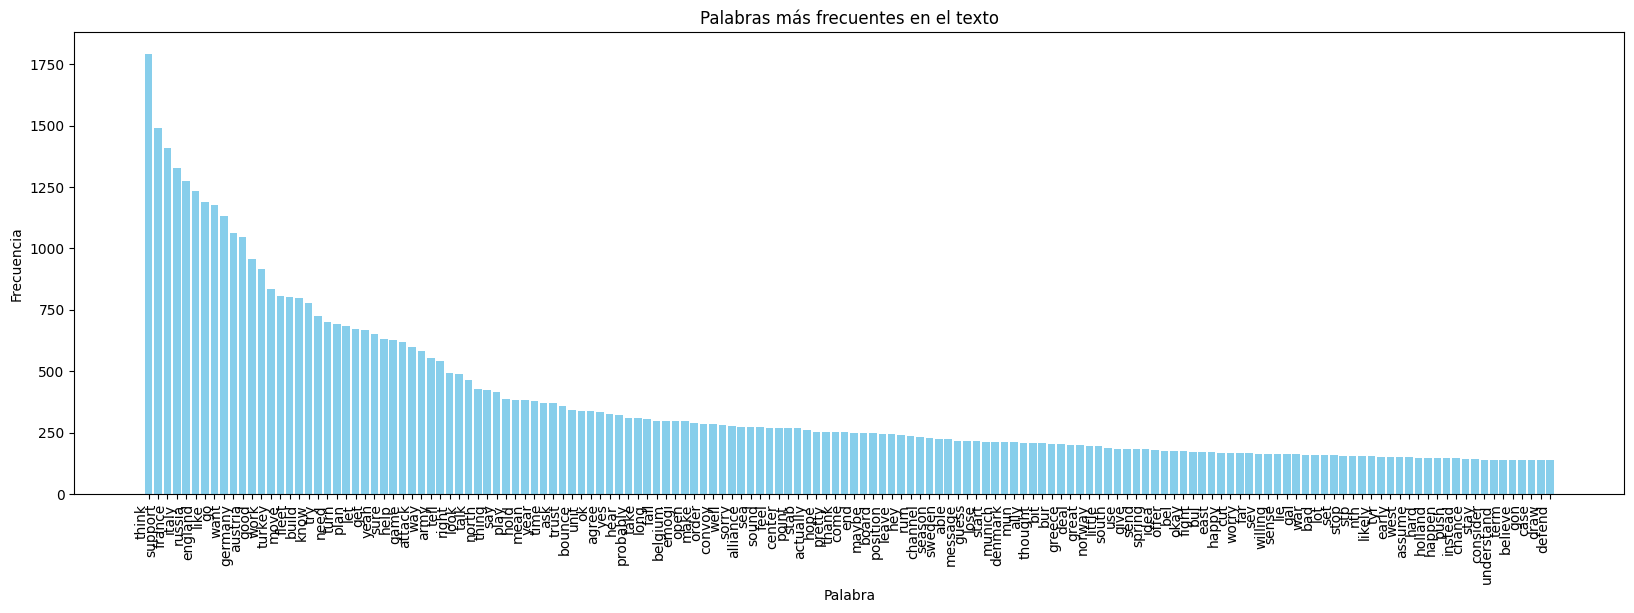

In [1237]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist


# Tokenizar el texto y calcular la frecuencia de las palabras
tokens = [word.lower() for text in train_tokenized['text'] for word in word_tokenize(text)]
freq_dist = FreqDist(tokens)

# Obtener las 10 palabras más frecuentes
top_words = freq_dist.most_common(150) # [:-101:-1]

# Crear un DataFrame para la visualización
df_top_words = pd.DataFrame(top_words, columns=['Palabra', 'Frecuencia'])

# Graficar las palabras más frecuentes
plt.figure(figsize=(20, 6))
plt.bar(df_top_words['Palabra'], df_top_words['Frecuencia'], color='skyblue')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.title('Palabras más frecuentes en el texto')
plt.xticks(rotation=90, ha='right')
plt.show()


De manera visual podemos saber cuales son los stopwords que utiliza el modelo spacy

In [1238]:
# Obtener la lista de stopwords en inglés
stopwords_spacy = nlp.Defaults.stop_words

# Mostrar la lista de stopwords
print("Stopwords en spaCy:", stopwords_spacy)

Stopwords en spaCy: {'', 'well', 'still', 'toward', 'from', 'g', 'afterwards', 'over', 'be', 'ho', 'among', 'own', 'too', 'hahaha', 'on', 'being', 'lol', 'anyway', 'further', 'after', 'per', 'whither', 'whereafter', 'were', 'then', 'in', '‘d', 'beside', 'hereafter', 'less', 'should', 'though', 'whoever', 'made', 'moreover', 'give', 'that', 'often', 'became', 'six', 'even', 'your', 'himself', "'d", 'top', 'such', 'eleven', 'everything', 'amongst', 'go', 'if', 'h', 'whereby', 'why', 'becomes', 'several', 'somehow', 'any', 'sixty', 'hereby', 'have', 'amount', 'mao', 'yours', 'serious', 'and', 'more', 'hundred', 'not', 'around', 'mine', 'put', 'down', 'm', 'now', 'namely', '‘m', 'somewhere', 'the', 'ah', 'latterly', 'our', '‘s', 'can', 'someone', "n't", 'f', 'these', '‘ve', 'could', 'between', 'others', 'across', 'while', 'nowhere', '’ve', 'may', 'three', "'re", 'its', 'anything', 'his', 'via', 'without', 'few', 'a', 'something', 'two', 'oh', 'cannot', 'their', 'neither', 'am', 'anyhow', '

In [436]:
# Definir las características
features = Features({
    'label': ClassLabel(names=[0, 1], id=None),
    'text': Value(dtype='string', id=None),
    'input_ids': Sequence(feature=Value(dtype='int64', id=None)),
    'attention_mask': Sequence(feature=Value(dtype='int64', id=None)) 
})  

train_tokenized.reset_index(drop=True, inplace=True)

# Crear el conjunto de datos
train_dataset = Dataset.from_pandas(train_tokenized, features=features)
test_dataset = Dataset.from_pandas(test_tokenized, features=features) 
validation_dataset = Dataset.from_pandas(validation_tokenized, features=features)

In [438]:
dataset_dict = DatasetDict({
    "train": train_dataset,
    "test": test_dataset,
    "validation": validation_dataset,
})

In [439]:
dataset_dict 

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 13132
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 2741
    })
    validation: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1416
    })
})

In [231]:
# Se crea un recopilador de datos, que rellenara dinámicamente los ejemplos en cada lote durante el entrenamiento 
# de modo que todos tengan la misma longitud. Esto es computacionalmente más eficiente que rellenar todos los ejemplos para que tengan la misma longitud 
# en todo el conjunto de datos.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Metrica de evaluacion

In [233]:
# import accuracy evaluation metric
accuracy = evaluate.load("accuracy")

# se define una funcion de evaluacion que sera utilizada en el entranmiento
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)}

# Modelo 1 - BASELINE de entrenamiento

Esta configuracion se basa en el articulo:

loRA: LOW-RANK ADAPTATION OF LARGE LANGUAGE MODELS - 2021 </br>
Edward Hu∗ Yelong Shen∗ Phillip Wallis Zeyuan Allen-Zhu </br>
Yuanzhi Li Shean Wang Lu Wang Weizhu Chen

Una red neuronal contiene muchas capas densas que realizan la multiplicación de matrices. Las matrices de peso en estas capas suelen tener rango completo. Al adaptarse a una tarea específica, muestra que los modelos de lenguaje previamente entrenados tienen una "dimensión instrinseca" baja y aún pueden aprender de manera eficiente a pesar de una proyeccion aleatoria a un subespacio más pequeño. A raiz de esto, se plantea la hipotesis de que las actualizaciones de las ponderaciones también tienen un "rango intrínseco" bajo durante la adaptacion.

Al aplicar LoRA a todas las matrices de peso y entrenar todos los sesgos, recuperamos aproximadamente la expresividad del ajuste fino completo al establecer el rango r de LoRA en el rango de las matrices de peso previamente entrenadas. En otras palabras, a medida que aumentamos la cantidad de parámetros entrenables, el entrenamiento de LoRA converge aproximadamente al entrenamiento del modelo original.

LoRA se basa en truncar la descomposicion de valores singulares (SVD) de una matriz de rango superior para obtener la aproximacion. </br>
Es posible encontrar una aproximación de rango reducida a A estableciendo todos, excepto los primeros k valores singulares más grandes, iguales a cero y usando solo las primeras k columnas de U y V, en la ecuación: A = U * S * V(T). Ademas, de reemplazar por ser los valores singulares mas pequeños en la diagonal de S. </br>
Despues de un fine tunning, las matrices de rango bajo se pueden reconstruir en matrices de rango completo usando la misma tecnica de descomposición, y el modelo de lenguaje grande (LLM) adaptado resultante, se puede usar para tareas posteriores en el nuevo dominio.

LoRA es el proceso de representar la información en una Matriz M utilizando una matriz M2 que tiene un rango menor que la matriz original. Para reducir el rango de M2, podemos intentar construir la matriz como una combinación de una matriz izquierda Lk y una matriz amplia derecha Rk transpuesta.

Por ejemlpo para una capa de una red neuronal se tiene:

h(x) = W0 * x + delta W * x   siendo : delta W = BA
Entonces:

h(x) = W0 * x + B * A * X 

DONDE :

W0 pertenece a todo R elevado a (d x k)</br>
B pertenece a todo R elevado a (d x r)</br>
A pertecene a todo R elevado a (r x k)</br>
h pertenece a todo R elevado a (d x 1)</br>

siendo r, un factor mutiplicador que define el tamaño de la matrix B y A que corresponden a los pesos que seran entrenados en la red neuronal y dejando congelado el peso de W0. 
Este valor de r es el que se ve en la siguiente linea de codigo r = 4. Hay un termino adicional alpha que multiplica a: alpha*B*A*x que se traduce como un  para la reparametrizacion de LoRA.

Algunas ventajas de esta tecnica son: 
- la reduccion de ruido</br>
- compresion de las matrices para reducir el gaste computacional </br>
- detecta patrones escondidos en los datos.</br>
- Parameter efficient fine tunning  -LoRA (Low Rank Adaptation) una proyeccion aleatoria a un pequeño subespacio</br>
- LoRA: congela los pesos de los modelos previamente entrenados e introduce matrices de descomposicion de rangos entrenables en cada capa del transformer.</br>
- Fine tunning implica copiar los pesos de la red previamente entrenada y ajustarlos en la tarea posterior (un nuevo conjunto de pesos de cada tarea).</br>
- LoRA reduce el numero de paramtros entrenables por 10,000 veces y los requerimientos de la memoria de la GPU por 3 veces.</br>

In [234]:
peft_config = LoraConfig(task_type="SEQ_CLS", # sequence classification
                        r=4, # intrinsic rank of trainable weight matrix
                        lora_alpha=32, # used for scalling the LoRA reparametrization .
                        lora_dropout=0.01, # probablity of dropout
                        target_modules = ['q_lin']) # we apply LoRA to query layer only

creamos una nueva version de nuestro modelo que se puede entrenar mediante PEFT (parameter efficient fine tunning).

In [235]:
# podemos ver como quedo la configuracion
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=4, target_modules={'q_lin'}, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={})

In [236]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 628,994 || all params: 67,584,004 || trainable%: 0.9306847223789819


In [313]:
# hyperparametros
lr = 1e-3 # size of optimization step 
batch_size = 4 # number of examples processed per optimziation step
num_epochs = 10 # number of times model runs through training data

# define training arguments
training_args = TrainingArguments(
    output_dir= modelo + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [440]:
# creater trainer object
trainer = Trainer(
    model=model, # our peft model
    args=training_args, # hyperparameters
    train_dataset= dataset_dict['train'], # training data 
    eval_dataset=dataset_dict['test'], # test data  
    tokenizer=tokenizer, # define tokenizer
    data_collator=data_collator, # this will dynamically pad examples in each batch to be equal length
    compute_metrics=compute_metrics, # evaluates model using compute_metrics() function from before
)

# train model
trainer.train()

  3%|▎         | 501/16415 [00:47<24:00, 11.05it/s]

{'loss': 102.8817, 'learning_rate': 0.09695400548279014, 'epoch': 0.15}


  6%|▌         | 1002/16415 [01:31<21:26, 11.98it/s]

{'loss': 30.4656, 'learning_rate': 0.09390801096558027, 'epoch': 0.3}


  9%|▉         | 1502/16415 [02:15<20:39, 12.03it/s]

{'loss': 8.8291, 'learning_rate': 0.0908620164483704, 'epoch': 0.46}


 12%|█▏        | 2001/16415 [02:58<18:56, 12.69it/s]

{'loss': 13.1447, 'learning_rate': 0.08781602193116053, 'epoch': 0.61}


 15%|█▌        | 2501/16415 [03:41<18:20, 12.65it/s]

{'loss': 3.7788, 'learning_rate': 0.08477002741395066, 'epoch': 0.76}


 18%|█▊        | 3001/16415 [04:24<18:11, 12.29it/s]

{'loss': 2.014, 'learning_rate': 0.0817240328967408, 'epoch': 0.91}


 20%|█▉        | 3282/16415 [04:56<22:13,  9.85it/s]Trainer is attempting to log a value of "{'accuracy': 0.9124407150674936}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                    
 20%|██        | 3283/16415 [05:22<22:13,  9.85it/s]

{'eval_loss': 0.3233390152454376, 'eval_accuracy': {'accuracy': 0.9124407150674936}, 'eval_runtime': 26.104, 'eval_samples_per_second': 105.003, 'eval_steps_per_second': 26.28, 'epoch': 1.0}


 21%|██▏       | 3501/16415 [05:46<21:29, 10.01it/s]   

{'loss': 0.2238, 'learning_rate': 0.07867803837953091, 'epoch': 1.07}


 24%|██▍       | 4001/16415 [06:36<19:18, 10.72it/s]

{'loss': 0.2041, 'learning_rate': 0.07563204386232106, 'epoch': 1.22}


 27%|██▋       | 4500/16415 [07:24<15:59, 12.41it/s]

{'loss': 0.195, 'learning_rate': 0.07258604934511119, 'epoch': 1.37}


 30%|███       | 5000/16415 [08:10<15:11, 12.53it/s]

{'loss': 0.1698, 'learning_rate': 0.06954005482790131, 'epoch': 1.52}


 34%|███▎      | 5501/16415 [08:57<16:22, 11.11it/s]

{'loss': 0.1799, 'learning_rate': 0.06649406031069144, 'epoch': 1.68}


 37%|███▋      | 6001/16415 [09:46<15:12, 11.41it/s]

{'loss': 0.1906, 'learning_rate': 0.06344806579348157, 'epoch': 1.83}


 40%|███▉      | 6501/16415 [10:32<13:57, 11.83it/s]

{'loss': 0.1929, 'learning_rate': 0.06040207127627171, 'epoch': 1.98}


 40%|████      | 6566/16415 [10:52<15:59, 10.26it/s]Trainer is attempting to log a value of "{'accuracy': 0.9124407150674936}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                    
 40%|████      | 6566/16415 [11:09<15:59, 10.26it/s]

{'eval_loss': 0.3010021448135376, 'eval_accuracy': {'accuracy': 0.9124407150674936}, 'eval_runtime': 31.8922, 'eval_samples_per_second': 85.946, 'eval_steps_per_second': 21.51, 'epoch': 2.0}


 43%|████▎     | 7001/16415 [12:02<23:54,  6.56it/s]   

{'loss': 0.2016, 'learning_rate': 0.05735607675906184, 'epoch': 2.13}


 46%|████▌     | 7502/16415 [12:55<12:58, 11.44it/s]

{'loss': 0.1457, 'learning_rate': 0.054310082241851965, 'epoch': 2.28}


 49%|████▊     | 8001/16415 [13:44<13:09, 10.65it/s]

{'loss': 0.1964, 'learning_rate': 0.051264087724642096, 'epoch': 2.44}


 52%|█████▏    | 8502/16415 [14:35<10:43, 12.29it/s]

{'loss': 0.182, 'learning_rate': 0.04821809320743223, 'epoch': 2.59}


 55%|█████▍    | 9002/16415 [15:24<11:17, 10.94it/s]

{'loss': 0.1938, 'learning_rate': 0.04517209869022236, 'epoch': 2.74}


 58%|█████▊    | 9501/16415 [16:08<09:47, 11.77it/s]

{'loss': 0.1889, 'learning_rate': 0.04212610417301249, 'epoch': 2.89}


 60%|██████    | 9849/16415 [16:52<09:28, 11.56it/s]Trainer is attempting to log a value of "{'accuracy': 0.9124407150674936}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                    
 60%|██████    | 9849/16415 [16:59<09:28, 11.56it/s]

{'eval_loss': 0.30191779136657715, 'eval_accuracy': {'accuracy': 0.9124407150674936}, 'eval_runtime': 20.2982, 'eval_samples_per_second': 135.036, 'eval_steps_per_second': 33.796, 'epoch': 3.0}


 61%|██████    | 10000/16415 [17:14<10:30, 10.17it/s] 

{'loss': 0.1919, 'learning_rate': 0.03908010965580262, 'epoch': 3.05}


 64%|██████▍   | 10501/16415 [17:58<08:17, 11.89it/s]

{'loss': 0.1851, 'learning_rate': 0.03603411513859275, 'epoch': 3.2}


 67%|██████▋   | 11002/16415 [18:42<07:09, 12.59it/s]

{'loss': 0.1868, 'learning_rate': 0.032988120621382885, 'epoch': 3.35}


 70%|███████   | 11501/16415 [19:27<07:00, 11.68it/s]

{'loss': 0.2092, 'learning_rate': 0.029942126104173013, 'epoch': 3.5}


 73%|███████▎  | 12001/16415 [20:14<06:36, 11.12it/s]

{'loss': 0.1941, 'learning_rate': 0.02689613158696315, 'epoch': 3.66}


 76%|███████▌  | 12502/16415 [21:00<05:24, 12.05it/s]

{'loss': 0.1611, 'learning_rate': 0.023850137069753276, 'epoch': 3.81}


 79%|███████▉  | 13002/16415 [21:48<04:36, 12.32it/s]

{'loss': 0.1922, 'learning_rate': 0.020804142552543408, 'epoch': 3.96}


 80%|████████  | 13132/16415 [22:02<06:12,  8.81it/s]Trainer is attempting to log a value of "{'accuracy': 0.9124407150674936}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                     
 80%|████████  | 13132/16415 [22:29<06:12,  8.81it/s]

{'eval_loss': 0.3318105936050415, 'eval_accuracy': {'accuracy': 0.9124407150674936}, 'eval_runtime': 27.6475, 'eval_samples_per_second': 99.141, 'eval_steps_per_second': 24.812, 'epoch': 4.0}


 82%|████████▏ | 13501/16415 [23:05<04:49, 10.06it/s]  

{'loss': 0.1518, 'learning_rate': 0.01775814803533354, 'epoch': 4.11}


 85%|████████▌ | 14002/16415 [23:51<03:25, 11.75it/s]

{'loss': 0.2244, 'learning_rate': 0.014712153518123668, 'epoch': 4.26}


 88%|████████▊ | 14501/16415 [24:39<02:50, 11.21it/s]

{'loss': 0.1915, 'learning_rate': 0.0116661590009138, 'epoch': 4.42}


 91%|█████████▏| 15001/16415 [25:29<02:24,  9.76it/s]

{'loss': 0.1813, 'learning_rate': 0.008620164483703929, 'epoch': 4.57}


 94%|█████████▍| 15500/16415 [26:22<01:29, 10.21it/s]

{'loss': 0.1809, 'learning_rate': 0.0055741699664940605, 'epoch': 4.72}


 97%|█████████▋| 16002/16415 [27:09<00:33, 12.25it/s]

{'loss': 0.1793, 'learning_rate': 0.0025281754492841916, 'epoch': 4.87}


100%|██████████| 16415/16415 [28:03<00:00, 12.59it/s]Trainer is attempting to log a value of "{'accuracy': 0.9124407150674936}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                     
100%|██████████| 16415/16415 [28:10<00:00, 12.59it/s]

{'eval_loss': 0.3192318379878998, 'eval_accuracy': {'accuracy': 0.9124407150674936}, 'eval_runtime': 21.5712, 'eval_samples_per_second': 127.067, 'eval_steps_per_second': 31.802, 'epoch': 5.0}


100%|██████████| 16415/16415 [28:10<00:00,  9.71it/s]

{'train_runtime': 1690.6842, 'train_samples_per_second': 38.836, 'train_steps_per_second': 9.709, 'train_loss': 5.060581707613083, 'epoch': 5.0}


TrainOutput(global_step=16415, training_loss=5.060581707613083, metrics={'train_runtime': 1690.6842, 'train_samples_per_second': 38.836, 'train_steps_per_second': 9.709, 'train_loss': 5.060581707613083, 'epoch': 5.0})

In [482]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("Trained model predictions:")
print("--------------------------")
for text in train_tokenized[['text']].iloc[1]:  
    # Tokeniza y codifica el texto
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    # Realiza la inferencia en el modelo
    logits = model(inputs).logits
    predictions = torch.max(logits, 1).indices
    print(id2label[predictions.tolist()[0]]) 

    print(text + " - " + id2label[predictions.tolist()[0]])

Trained model predictions:
--------------------------
True
whet appetite italy suggestion - True


In [494]:
# realizamos las predicciones para los datos de testeo para calcular las metricas y ver la calidad del modelo con los datos utilizados
prediction_f = []
for index, row in test_tokenized.iterrows(): 
    text = row['text']

    # Tokeniza y codifica el texto
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    # Realiza la inferencia en el modelo
    logits = model(inputs).logits
    predictions = torch.max(logits, 1).indices
    prediction_f.append([text, predictions.tolist()[0]])
if len(prediction_f) > 0:
    result = pd.DataFrame(prediction_f).rename(columns={0:'text',1:'label_predicted'})

In [495]:
from sklearn.metrics import accuracy_score, confusion_matrix


accuracy = accuracy_score(test_tokenized['label'], result['label_predicted'])
print(f'Accuracy: {accuracy:.2f}')

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(test_tokenized['label'], result['label_predicted'])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.91
Confusion Matrix:
[[   0  240]
 [   0 2501]]


El accuracy representa el porcentaje total de valores correctamente clasificados, tanto negativos como positivos, en este caso en particular se obtiene un valor muy alto ya que la clase mayoritaria de 1 esta bien clasificada lo cual corresponde a ese 91% mientras que el restante que son 0 es decir la mentira, no se clasifican correctamente.

d:\rn\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\rn\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\rn\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


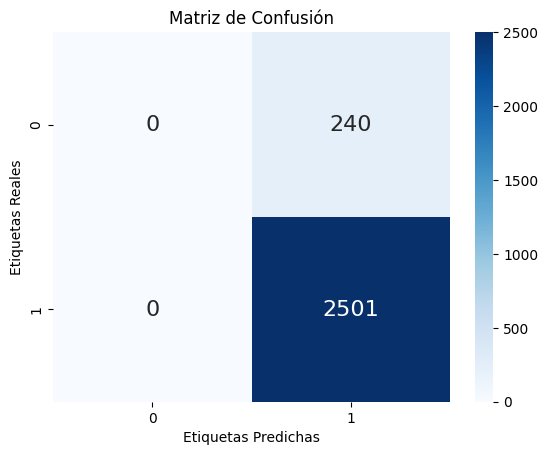

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       240
           1       0.91      1.00      0.95      2501

    accuracy                           0.91      2741
   macro avg       0.46      0.50      0.48      2741
weighted avg       0.83      0.91      0.87      2741



In [506]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(test_tokenized['label'], result['label_predicted'])

# Calcula el reporte de clasificación
class_report = classification_report(test_tokenized['label'], result['label_predicted'])

# Crea un mapa de calor de la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Reales')
plt.title('Matriz de Confusión')
plt.show()

# Imprime el reporte de clasificación
print("Reporte de Clasificación:")
print(class_report)

# Conclusion 1

Se puede observar una buena precision en el modelo, sin embargo la matrix de confusion me dice que los datos predicen muy bien para la clase mayoritaria, sin embargo para la clase minoritaria no es capaz de detectar la categoria cero que representa la mentira. Claramente me indica que el modelo esta sobreajustando el resultado.
Esto se explica facilmente debido al desbalance de clases que se presentan en los datos, ademas es posible probar mas hiperparametros y tratar de mejorar el score de la metrica y tratar los falsos positivos. </br>

El recall da cuenta sobre cuantos valores positivos son correctamente clasificados, eb este caso el mejor recall es para la prediccion de 1 (verdad), mientras que para 0 el recall es muy bajo. </br>

La precision me explica cuanto porcentaje de valores que se han clasificado como positivos son realmente positivos, en este caso para el valor de 1 la precision toma un valor de 0.91 o un 91%. </br>

El F1-score me da un buen balance entre la precision y el recall, manteniendome lejos de los falsos positivos y falsos negativos, si buen para la clasificacion de 1 es 0.95, es evidente que para 0 el f1 = 0, es decir todos son falsos positivos. 

Finalmente realizamos las predicciones para el set de validacion. 

In [497]:
prediction_f2 = []
for index, row in validation_tokenized.iterrows():  
    text = row['text']

    # Tokeniza y codifica el texto
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    # Realiza la inferencia en el modelo
    logits = model(inputs).logits
    predictions = torch.max(logits, 1).indices
    prediction_f2.append([text, predictions.tolist()[0]])
if len(prediction_f2) > 0:
    result2 = pd.DataFrame(prediction_f2).rename(columns={0:'text',1:'label_predicted'})

In [508]:
result2

,text,label_predicted
0,good afternoon friend south send message open ...,1
1,course thank future kaissereich effect neighbo...,1
2,french turn thorn greatly appreciate aid,1
3,greeting new italy,1
4,like reiterate italy likely opportunistic stan...,1
...,...,...
1411,austria importand italy england basically game...,1
1412,hello turkey,1
1413,hello,1
1414,helloo turkey,1


Para este caso las predicciones del label son todas 1, debido al sobreajuste que se presenta en los datos

# Modelo 2 - Dataset balanceado

Para tratar el desbalance que existe en los datos, aplicaremos una tecnica de resampleo sencilla para mantener la cantidad de datos de la clase minoritaria, disminuyendo asi para la clase 0 y 1 en 591 datos respectivamente. 
Despues de esto se entrenara el modelo nuevamente y obtendremos las metricas de evaluacion del modelo de hugging face

In [1123]:
################################################### DATA #################################################

# Aplicar la función a cada fila del DataFrame
input_ids_train, attention_mask_train = tokenize_and_pad(train_messages2, 'text2', tokenizer)
train_tokenized = train_messages2.copy()
train_tokenized['input_ids'] = list(input_ids_train)
train_tokenized['attention_mask'] = list(attention_mask_train)

# Aplicar la función a cada fila del DataFrame
input_ids_test, attention_mask_test = tokenize_and_pad(test_messages2, 'text2', tokenizer)
test_tokenized = test_messages2.copy()
test_tokenized['input_ids'] = list(input_ids_test)
test_tokenized['attention_mask'] = list(attention_mask_test)


# Aplicar la función a cada fila del DataFrame
input_ids_validation, attention_mask_validation = tokenize_and_pad(validation_messages2, 'text2', tokenizer)
validation_tokenized = validation_messages2.copy()
validation_tokenized['input_ids'] = list(input_ids_validation)
validation_tokenized['attention_mask'] = list(attention_mask_validation)

# Renombramos la columna text
train_tokenized = train_tokenized.drop(columns = {'text'}) 
train_tokenized = train_tokenized.rename(columns = {'text2':'text'}) 
train_tokenized = train_tokenized[['label','text','input_ids','attention_mask']]

test_tokenized = test_tokenized.drop(columns = {'text'}) 
test_tokenized = test_tokenized.rename(columns = {'text2':'text'}) 
test_tokenized = test_tokenized[['label','text','input_ids','attention_mask']]

validation_tokenized = validation_tokenized.drop(columns = {'text'}) 
validation_tokenized = validation_tokenized.rename(columns = {'text2':'text'}) 
validation_tokenized = validation_tokenized[['label','text','input_ids','attention_mask']] 

trainable params: 628,994 || all params: 67,584,004 || trainable%: 0.9306847223789819


 20%|██        | 394/1970 [00:41<02:09, 12.19it/s]Trainer is attempting to log a value of "{'accuracy': 0.7121488507843853}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                  
 20%|██        | 395/1970 [00:59<1:52:14,  4.28s/it]

{'eval_loss': 0.6163405179977417, 'eval_accuracy': {'accuracy': 0.7121488507843853}, 'eval_runtime': 27.8404, 'eval_samples_per_second': 98.454, 'eval_steps_per_second': 32.83, 'epoch': 1.0}


 25%|██▌       | 501/1970 [01:07<01:56, 12.57it/s]  

{'loss': 0.7293, 'learning_rate': 0.0007461928934010153, 'epoch': 1.27}


 40%|████      | 788/1970 [01:41<01:29, 13.23it/s]Trainer is attempting to log a value of "{'accuracy': 0.35388544326888}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                  
 40%|████      | 789/1970 [01:57<1:23:12,  4.23s/it]

{'eval_loss': 0.9187417030334473, 'eval_accuracy': {'accuracy': 0.35388544326888}, 'eval_runtime': 27.5411, 'eval_samples_per_second': 99.524, 'eval_steps_per_second': 33.187, 'epoch': 2.0}


 51%|█████     | 1001/1970 [02:13<01:19, 12.17it/s] 

{'loss': 0.6775, 'learning_rate': 0.0004923857868020305, 'epoch': 2.54}


 60%|██████    | 1182/1970 [02:41<01:00, 12.93it/s]Trainer is attempting to log a value of "{'accuracy': 0.6202116016052536}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                   
 60%|██████    | 1182/1970 [02:55<01:00, 12.93it/s]Checkpoint destination directory distilbert-base-uncased-lora-text-classification\checkpoint-1182 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6564392447471619, 'eval_accuracy': {'accuracy': 0.6202116016052536}, 'eval_runtime': 27.4101, 'eval_samples_per_second': 100.0, 'eval_steps_per_second': 33.345, 'epoch': 3.0}


 76%|███████▌  | 1501/1970 [03:20<00:38, 12.14it/s]

{'loss': 0.6195, 'learning_rate': 0.0002385786802030457, 'epoch': 3.81}


 80%|████████  | 1576/1970 [03:41<00:31, 12.42it/s]Trainer is attempting to log a value of "{'accuracy': 0.6037942356804086}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                   
 80%|████████  | 1577/1970 [03:53<27:24,  4.19s/it]

{'eval_loss': 0.7804359793663025, 'eval_accuracy': {'accuracy': 0.6037942356804086}, 'eval_runtime': 27.247, 'eval_samples_per_second': 100.598, 'eval_steps_per_second': 33.545, 'epoch': 4.0}


100%|██████████| 1970/1970 [04:41<00:00, 12.20it/s]Trainer is attempting to log a value of "{'accuracy': 0.5640277271068953}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                   
100%|██████████| 1970/1970 [04:58<00:00,  6.59it/s]


{'eval_loss': 0.9033320546150208, 'eval_accuracy': {'accuracy': 0.5640277271068953}, 'eval_runtime': 32.0962, 'eval_samples_per_second': 85.4, 'eval_steps_per_second': 28.477, 'epoch': 5.0}
{'train_runtime': 298.8125, 'train_samples_per_second': 19.778, 'train_steps_per_second': 6.593, 'train_loss': 0.6509274400430283, 'epoch': 5.0}
Trained model predictions:
--------------------------
True
whet appetite italy suggestion - True
Accuracy: 0.71
Confusion Matrix:
[[ 106  134]
 [ 655 1846]]


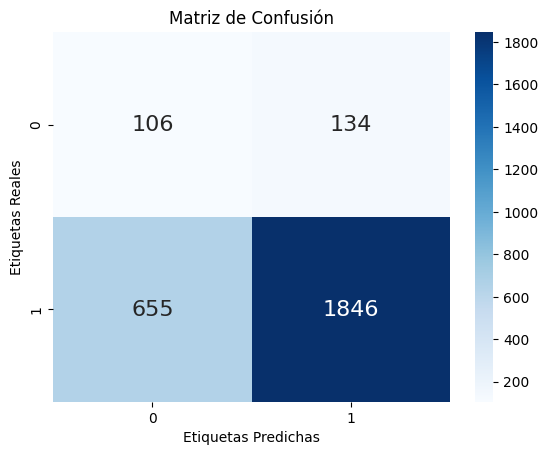

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.14      0.44      0.21       240
           1       0.93      0.74      0.82      2501

    accuracy                           0.71      2741
   macro avg       0.54      0.59      0.52      2741
weighted avg       0.86      0.71      0.77      2741



In [1125]:
from sklearn.utils import resample
df_class_0 = train_tokenized[train_tokenized['label'] == 0]
df_class_1 = train_tokenized[train_tokenized['label'] == 1]

# Submuestrear la clase mayoritaria (clase 1) a 591 instancias
df_class_1_resampled = resample(df_class_1, replace=False, n_samples=591, random_state=42)

# Combinar las clases equilibradas
df_balanced = pd.concat([df_class_0, df_class_1_resampled]).reset_index(drop = True) 


# Definir las características
features = Features({
    'label': ClassLabel(names=[0, 1], id=None),
    'text': Value(dtype='string', id=None),
    'input_ids': Sequence(feature=Value(dtype='int64', id=None)),
    'attention_mask': Sequence(feature=Value(dtype='int64', id=None)) 
})  


df_balanced_.reset_index(drop=True, inplace=True)

# Crear el conjunto de datos
train_dataset = Dataset.from_pandas(df_balanced, features=features)
test_dataset = Dataset.from_pandas(test_tokenized, features=features) 
validation_dataset = Dataset.from_pandas(validation_tokenized, features=features)


dataset_dict = DatasetDict({
    "train": train_dataset,
    "test": test_dataset,
    "validation": validation_dataset,
})

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# import accuracy evaluation metric
accuracy = evaluate.load("accuracy")

# se define una funcion de evaluacion que sera utilizada en el entranmiento
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)}

peft_config = LoraConfig(task_type="SEQ_CLS", # sequence classification
                        r=4, # intrinsic rank of trainable weight matrix
                        lora_alpha=32, # used for scalling the LoRA reparametrization .
                        lora_dropout=0.01, # probablity of dropout
                        target_modules = ['q_lin']) # we apply LoRA to query layer only

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# hyperparametros
lr = 0.001# size of optimization step 
batch_size = 3 # number of examples processed per optimziation step
num_epochs = 5 # number of times model runs through training data

# define training arguments
training_args = TrainingArguments(
    output_dir= modelo + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)


# creater trainer object
trainer2 = Trainer(
    model=model, # our peft model
    args=training_args, # hyperparameters
    train_dataset= dataset_dict['train'], # training data 
    eval_dataset=dataset_dict['test'], # test data  
    tokenizer=tokenizer, # define tokenizer
    data_collator=data_collator, # this will dynamically pad examples in each batch to be equal length
    compute_metrics=compute_metrics, # evaluates model using compute_metrics() function from before
)

# train model
trainer2.train()

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("Trained model predictions:")
print("--------------------------")
for text in train_tokenized[['text']].iloc[1]:  
    # Tokeniza y codifica el texto
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    # Realiza la inferencia en el modelo
    logits = model(inputs).logits
    predictions = torch.max(logits, 1).indices
    print(id2label[predictions.tolist()[0]]) 

    print(text + " - " + id2label[predictions.tolist()[0]])


# realizamos las predicciones para los datos de testeo para calcular las metricas y ver la calidad del modelo con los datos utilizados
prediction_f = []
for index, row in test_tokenized.iterrows(): 
    text = row['text']

    # Tokeniza y codifica el texto
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    # Realiza la inferencia en el modelo
    logits = model(inputs).logits
    predictions = torch.max(logits, 1).indices
    prediction_f.append([text, predictions.tolist()[0]])
if len(prediction_f) > 0:
    result = pd.DataFrame(prediction_f).rename(columns={0:'text',1:'label_predicted'})


from sklearn.metrics import accuracy_score, confusion_matrix


accuracy = accuracy_score(test_tokenized['label'], result['label_predicted'])
print(f'Accuracy: {accuracy:.2f}')

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(test_tokenized['label'], result['label_predicted'])
print('Confusion Matrix:')
print(conf_matrix)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(test_tokenized['label'], result['label_predicted'])

# Calcula el reporte de clasificación
class_report = classification_report(test_tokenized['label'], result['label_predicted'])

# Crea un mapa de calor de la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Reales')
plt.title('Matriz de Confusión')
plt.show()

# Imprime el reporte de clasificación
print("Reporte de Clasificación:")
print(class_report)

# Conclusion 2

Se puede observar una disminucion en la precision en el modelo, sin embargo la matrix de confusion evidencia un gran porcentaje en falsos positivos y falsos negativos, para la clase minoritaria respecto a su mimsma proporcion de clases, la etiqueta de 0 clasifica la mayor cantidad como falsos positivos. En este caso se modifico el sobreajuste en los datos, pero sigue sin ser un buen modelo ya que no identifica correctamente las mentiras. 

El recall da cuenta sobre cuantos valores positivos son correctamente clasificados, en este caso el recall  para la prediccion de 1 (verdad) =  0.74, mientras que para 0 el recall es = 0.44. </br>

La precision me explica cuanto porcentaje de valores que se han clasificado como positivos son realmente positivos, en este caso para el valor de 1 la precision toma un valor de 0.93 o un 93% y para 0 toma el valor de 0.14, en este caso se concluye que el modelo tiene problemas para distinguir las mentiras de las verdades. </br>

El f1 score evidencia que para la clase cero falla casi en todo el tiempo (f1 = 0.21), mientras que para la clase 1 (f1 = 0.82) el valor es mayor. El f1 score alcanza su maximo cuando la precision y la exhaustividad son perfectas. Esta metrica es util en situaciones donde clasificar correctamente las instancias positivas es tan importante como minimizar los falsos positivos y los falsos negativos.

Finalmente, se predicen el label para los datos de validacion con el nuevo modelo entrenado con el sampleo de clases.

In [518]:
prediction_f2 = []
for index, row in validation_tokenized.iterrows():  
    text = row['text']

    # Tokeniza y codifica el texto
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    # Realiza la inferencia en el modelo
    logits = model(inputs).logits
    predictions = torch.max(logits, 1).indices
    prediction_f2.append([text, predictions.tolist()[0]])
if len(prediction_f2) > 0:
    result2 = pd.DataFrame(prediction_f2).rename(columns={0:'text',1:'label_predicted'})

In [519]:
result2 

,text,label_predicted
0,good afternoon friend south send message open ...,0
1,course thank future kaissereich effect neighbo...,0
2,french turn thorn greatly appreciate aid,1
3,greeting new italy,1
4,like reiterate italy likely opportunistic stan...,1
...,...,...
1411,austria importand italy england basically game...,1
1412,hello turkey,1
1413,hello,1
1414,helloo turkey,0


# Modelo 3 - game_Score 

En este caso, se utilizara la nueva columna de game_score y ver el efecto que tiene en el entrenamiento del modelo.

trainable params: 628,994 || all params: 67,584,004 || trainable%: 0.9306847223789819


 20%|██        | 394/1970 [00:50<02:11, 11.98it/s]Trainer is attempting to log a value of "{'accuracy': 0.575337468077344}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.

 20%|██        | 394/1970 [00:59<02:11, 11.98it/s]Checkpoint destination directory distilbert-base-uncased-lora-text-classification\checkpoint-394 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6902342438697815, 'eval_accuracy': {'accuracy': 0.575337468077344}, 'eval_runtime': 26.9749, 'eval_samples_per_second': 101.613, 'eval_steps_per_second': 33.883, 'epoch': 1.0}


 25%|██▌       | 501/1970 [01:08<02:17, 10.69it/s]  

{'loss': 0.7048, 'learning_rate': 0.0007461928934010153, 'epoch': 1.27}


 40%|████      | 788/1970 [01:50<01:32, 12.78it/s]Trainer is attempting to log a value of "{'accuracy': 0.3009850419554907}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                  
 40%|████      | 789/1970 [02:00<1:22:14,  4.18s/it]

{'eval_loss': 0.9290985465049744, 'eval_accuracy': {'accuracy': 0.3009850419554907}, 'eval_runtime': 27.2124, 'eval_samples_per_second': 100.726, 'eval_steps_per_second': 33.588, 'epoch': 2.0}


 51%|█████     | 1001/1970 [02:18<01:26, 11.19it/s] 

{'loss': 0.6984, 'learning_rate': 0.0004923857868020305, 'epoch': 2.54}


 60%|██████    | 1182/1970 [02:50<01:09, 11.30it/s]Trainer is attempting to log a value of "{'accuracy': 0.5107624954396206}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                   
 60%|██████    | 1182/1970 [03:12<01:09, 11.30it/s]Checkpoint destination directory distilbert-base-uncased-lora-text-classification\checkpoint-1182 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.7510913014411926, 'eval_accuracy': {'accuracy': 0.5107624954396206}, 'eval_runtime': 38.0, 'eval_samples_per_second': 72.132, 'eval_steps_per_second': 24.053, 'epoch': 3.0}


 76%|███████▌  | 1501/1970 [03:47<00:44, 10.61it/s]  

{'loss': 0.6453, 'learning_rate': 0.0002385786802030457, 'epoch': 3.81}


 80%|████████  | 1576/1970 [04:10<00:37, 10.64it/s]Trainer is attempting to log a value of "{'accuracy': 0.6030645749726378}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                   
 80%|████████  | 1576/1970 [04:26<00:37, 10.64it/s]Checkpoint destination directory distilbert-base-uncased-lora-text-classification\checkpoint-1576 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6941007971763611, 'eval_accuracy': {'accuracy': 0.6030645749726378}, 'eval_runtime': 32.7714, 'eval_samples_per_second': 83.64, 'eval_steps_per_second': 27.89, 'epoch': 4.0}


100%|██████████| 1970/1970 [05:10<00:00, 12.65it/s]Trainer is attempting to log a value of "{'accuracy': 0.5468807004742795}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                   
100%|██████████| 1970/1970 [05:26<00:00,  6.04it/s]


{'eval_loss': 0.817152202129364, 'eval_accuracy': {'accuracy': 0.5468807004742795}, 'eval_runtime': 26.4502, 'eval_samples_per_second': 103.629, 'eval_steps_per_second': 34.555, 'epoch': 5.0}
{'train_runtime': 326.3191, 'train_samples_per_second': 18.111, 'train_steps_per_second': 6.037, 'train_loss': 0.6657171413983185, 'epoch': 5.0}
Trained model predictions:
--------------------------
True
whet appetite italy suggestion - True
Accuracy: 0.58
Confusion Matrix:
[[ 154   86]
 [1078 1423]]


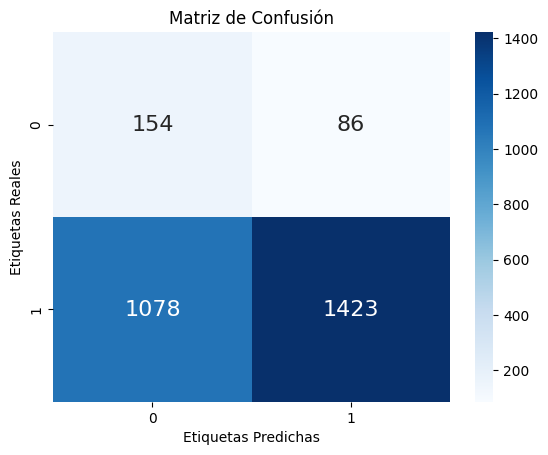

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.12      0.64      0.21       240
           1       0.94      0.57      0.71      2501

    accuracy                           0.58      2741
   macro avg       0.53      0.61      0.46      2741
weighted avg       0.87      0.58      0.67      2741



In [1107]:
from sklearn.utils import resample

train_tokenized2 = train_tokenized.copy() 
test_tokenized2 = test_tokenized.copy() 
validation_tokenized2 = validation_tokenized.copy() 

train_tokenized2['game_score'] = pd.DataFrame(train_data['game_score'].apply(pd.Series).stack().reset_index(level=1, drop=True).reset_index(drop = True)).rename(columns = {0:'game_score'})
test_tokenized2['game_score'] = pd.DataFrame(test_data['game_score'].apply(pd.Series).stack().reset_index(level=1, drop=True).reset_index(drop = True)).rename(columns = {0:'game_score'})
validation_tokenized2['game_score'] = pd.DataFrame(validation_data['game_score'].apply(pd.Series).stack().reset_index(level=1, drop=True).reset_index(drop = True)).rename(columns = {0:'game_score'})

train_tokenized2['game_score'] =  train_tokenized2['game_score'].astype(int) 
test_tokenized2['game_score'] =  test_tokenized2['game_score'].astype(int) 
validation_tokenized2['game_score'] =  validation_tokenized2['game_score'].astype(int) 

df_class_0 = train_tokenized2[train_tokenized2['label'] == 0] 
df_class_1 = train_tokenized2[train_tokenized2['label'] == 1]

# Submuestrear la clase mayoritaria (clase 1) a 591 instancias
df_class_1_resampled = resample(df_class_1, replace=False, n_samples=591, random_state=42) 

# Combinar las clases equilibradas
df_balanced = pd.concat([df_class_0, df_class_1_resampled]).reset_index(drop = True) 


# Definir las características
features = Features({
    'label': ClassLabel(names=[0, 1], id=None),
    'text': Value(dtype='string', id=None),
    'input_ids': Sequence(feature=Value(dtype='int64', id=None)),
    'attention_mask': Sequence(feature=Value(dtype='int64', id=None)),
    'game_score': Value(dtype='int8', id = None) 
})  

df_balanced.reset_index(drop=True, inplace=True)

# Crear el conjunto de datos
train_dataset = Dataset.from_pandas(df_balanced, features=features)
test_dataset = Dataset.from_pandas(test_tokenized2, features=features) 
validation_dataset = Dataset.from_pandas(validation_tokenized2, features=features)


dataset_dict = DatasetDict({
    "train": train_dataset,
    "test": test_dataset,
    "validation": validation_dataset,
})

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# import accuracy evaluation metric
accuracy = evaluate.load("accuracy")

# se define una funcion de evaluacion que sera utilizada en el entranmiento
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)}

peft_config = LoraConfig(task_type="SEQ_CLS", # sequence classification
                        r=4, # intrinsic rank of trainable weight matrix
                        lora_alpha=32, # used for scalling the LoRA reparametrization .
                        lora_dropout=0.01, # probablity of dropout
                        target_modules = ['q_lin']) # we apply LoRA to query layer only

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# hyperparametros
lr = 0.001# size of optimization step 
batch_size = 3 # number of examples processed per optimziation step
num_epochs = 5 # number of times model runs through training data

# define training arguments
training_args = TrainingArguments(
    output_dir= modelo + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)


# creater trainer object
trainer2 = Trainer(
    model=model, # our peft model
    args=training_args, # hyperparameters
    train_dataset= dataset_dict['train'], # training data 
    eval_dataset=dataset_dict['test'], # test data  
    tokenizer=tokenizer, # define tokenizer
    data_collator=data_collator, # this will dynamically pad examples in each batch to be equal length
    compute_metrics=compute_metrics, # evaluates model using compute_metrics() function from before
)

# train model
trainer2.train()

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("Trained model predictions:")
print("--------------------------")
for text in train_tokenized2[['text']].iloc[1]:  
    # Tokeniza y codifica el texto
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    # Realiza la inferencia en el modelo
    logits = model(inputs).logits
    predictions = torch.max(logits, 1).indices
    print(id2label[predictions.tolist()[0]]) 

    print(text + " - " + id2label[predictions.tolist()[0]])


# realizamos las predicciones para los datos de testeo para calcular las metricas y ver la calidad del modelo con los datos utilizados
prediction_f = []
for index, row in test_tokenized2.iterrows(): 
    text = row['text']

    # Tokeniza y codifica el texto
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    # Realiza la inferencia en el modelo
    logits = model(inputs).logits
    predictions = torch.max(logits, 1).indices
    prediction_f.append([text, predictions.tolist()[0]])
if len(prediction_f) > 0:
    result = pd.DataFrame(prediction_f).rename(columns={0:'text',1:'label_predicted'})


from sklearn.metrics import accuracy_score, confusion_matrix


accuracy = accuracy_score(test_tokenized['label'], result['label_predicted'])
print(f'Accuracy: {accuracy:.2f}')

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(test_tokenized['label'], result['label_predicted'])
print('Confusion Matrix:')
print(conf_matrix)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(test_tokenized['label'], result['label_predicted'])

# Calcula el reporte de clasificación
class_report = classification_report(test_tokenized['label'], result['label_predicted'])

# Crea un mapa de calor de la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Reales')
plt.title('Matriz de Confusión')
plt.show()

# Imprime el reporte de clasificación
print("Reporte de Clasificación:")
print(class_report)

# Conclusion 3

Se puede observar un cambio en la precision en el modelo, sin embargo la matrix de confusion evidencia un gran porcentaje en falsos positivos y falsos negativos, para la clase minoritaria respecto a su mimsma proporcion de clases, la etiqueta de 0 clasifica la mayor cantidad como falsos positivos. En este caso se añadio otra variable explicativa game_Score en los datos, pero sigue sin poder identificar correctamente las mentiras y la verdad. 

El recall da cuenta sobre cuantos valores positivos son correctamente clasificados, en este caso el recall  para la prediccion de 1 (verdad) =  0.75, mientras que para 0 el recall es = 0.44. </br>

La precision me explica cuanto porcentaje de valores que se han clasificado como positivos son realmente positivos, en este caso para el valor de 1 la precision toma un valor de 0.94 o un 94% y para 0 toma el valor de 0.12, en este caso se concluye que el modelo tiene problemas para distinguir las mentiras de las verdades. </br>

El f1 score evidencia que para la clase cero falla casi en todo el tiempo, mientras que para la clase 1, El f1 score alcanza su maximo cuando la precision y la exhaustividad son perfectas. Esta metrica es util en situaciones donde clasificar correctamente las instancias positivas es tan importante como minimizar los falsos positivos y los falsos negativos.

# Modelo 4

In [1118]:
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler

# Crear el scaler global
#global_scaler = MinMaxScaler()

def preprocess_data(train_tokenized2, tokenizer,df_speakers_OHE, use_fit_transform=True ):
    global global_scaler
    
    # Obtener los textos y tokenizar
    texts1 = train_tokenized2['text'].tolist()
    tokenized_inputs = tokenizer(texts1, padding=True, truncation=True, return_tensors="pt", max_length=112)

    # Obtener las variables exógenas
    exogenous_vars = train_tokenized2[['game_score']].values

    # Obtener los embeddings de las variables exógenas
    exogenous_vars_tensor = torch.tensor(exogenous_vars, dtype=torch.float32)

    # Concatenar los embeddings de las variables exógenas con los embeddings de texto
    combined_inputs = torch.cat([tokenized_inputs['input_ids'], exogenous_vars_tensor], dim=1)

    # Crear DataFrame
    w = pd.DataFrame(combined_inputs).astype(int)

    # Escalar los datos entre 0 y 1
    h = w.copy()
    columnas = w.columns
    num_cols_original = h.shape[1]
    if (num_cols_original == 113) and (use_fit_transform==True):
        # Ajustar el scaler global 
        w_scaled = pd.DataFrame(h, columns = columnas) # pd.DataFrame(global_scaler.fit_transform(h), columns=columnas )

        w_scaled = w_scaled.join(df_speakers_OHE)

        # Convertir todas las filas en una lista de listas
        secuencia_listas = w_scaled.values.tolist()

        # Crear nuevo DataFrame
        train_tokenized3 = train_tokenized2.copy()
        train_tokenized3['text'] = secuencia_listas
        train_tokenized3 = train_tokenized3[['label', 'text']]
        train_tokenized3 = train_tokenized3.rename(columns={'text': 'input_ids'})
        num_cols_original = w_scaled.shape[1]

        return train_tokenized3 
    
    else:
        num_zeros_to_add = 113 - num_cols_original 
        if num_zeros_to_add > 0:
            w2 = np.pad(h, ((0, 0), (0, num_zeros_to_add)), mode='constant', constant_values=0)
            w_scaled = pd.DataFrame(w2, columns = pd.RangeIndex(start=0, stop=113, step=1)) #pd.DataFrame(global_scaler.transform(w2), columns=pd.RangeIndex(start=0, stop=113, step=1) )

            w_scaled = w_scaled.join(df_speakers_OHE)

            # Convertir todas las filas en una lista de listas
            secuencia_listas = w_scaled.values.tolist()

            # Crear nuevo DataFrame
            train_tokenized3 = train_tokenized2.copy()
            train_tokenized3['text'] = secuencia_listas
            train_tokenized3 = train_tokenized3[['label', 'text']]
            train_tokenized3 = train_tokenized3.rename(columns={'text': 'input_ids'})
            num_cols_original = w_scaled.shape[1]

            return train_tokenized3 
        
        elif num_zeros_to_add == 0:
            w_scaled = pd.DataFrame(h, columns = columnas) #pd.DataFrame(global_scaler.transform(h), columns=columnas )

            w_scaled = w_scaled.join(df_speakers_OHE)

            # Convertir todas las filas en una lista de listas
            secuencia_listas = w_scaled.values.tolist()

            # Crear nuevo DataFrame
            train_tokenized3 = train_tokenized2.copy()
            train_tokenized3['text'] = secuencia_listas
            train_tokenized3 = train_tokenized3[['label', 'text']]
            train_tokenized3 = train_tokenized3.rename(columns={'text': 'input_ids'})
            

            return train_tokenized3
        else:
            w2 = h.iloc[num_zeros_to_add, :113] 
            w_scaled = pd.DataFrame(w2, columns = pd.RangeIndex(start=0, stop=113, step=1)) #pd.DataFrame(global_scaler.transform(w2), columns=pd.RangeIndex(start=0, stop=113, step=1))

            w_scaled = w_scaled.join(df_speakers_OHE)

            # Convertir todas las filas en una lista de listas
            secuencia_listas = w_scaled.values.tolist()

            # Crear nuevo DataFrame
            train_tokenized3 = train_tokenized2.copy()
            train_tokenized3['text'] = secuencia_listas
            train_tokenized3 = train_tokenized3[['label', 'text']]
            train_tokenized3 = train_tokenized3.rename(columns={'text': 'input_ids'})
      

            return train_tokenized3 



def onehot_encode_column(df, column_name):
    """
    Realiza one-hot encoding de una columna en un DataFrame.

    Parameters:
    - df: DataFrame original.
    - column_name: Nombre de la columna a codificar.

    Returns:
    - DataFrame con el one-hot encoding.
    """
    # Obtener la columna específica y aplicar one-hot encoding
    onehot_encoded = pd.get_dummies(df[column_name])
    # Cambiar valores booleanos a 0 y 1
    onehot_encoded = onehot_encoded.astype(int)

    # Fusionar el one-hot encoding con el DataFrame original
    df_encoded = pd.concat([df, onehot_encoded], axis=1)

    # Eliminar la columna original que fue codificada
    df_encoded = df_encoded.drop(column_name, axis=1)

    return df_encoded

# funcion para crear el attention mask para el modelo
def create_attention_mask(row):
    return [1 if token != 0 else 0 for token in row]


trainable params: 628,994 || all params: 67,584,004 || trainable%: 0.9306847223789819







































































































































































































































Trainer is attempting to log a value of "{'accuracy': 0.7292958774170011}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                        
                                               

  0%|          | 0/1970 [02:52<?, ?it/s]         

Checkpoint destination directory distilbert-base-uncased-lora-text-classification\checkpoint-394 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.5984054803848267, 'eval_accuracy': {'accuracy': 0.7292958774170011}, 'eval_runtime': 29.4081, 'eval_samples_per_second': 93.206, 'eval_steps_per_second': 31.08, 'epoch': 1.0}


                                        
  0%|          | 0/1970 [03:01<?, ?it/s]          

{'loss': 0.7355, 'learning_rate': 0.0007461928934010153, 'epoch': 1.27}

















































































































































































































































Trainer is attempting to log a value of "{'accuracy': 0.4206493980299161}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                        
                                               

  0%|          | 0/1970 [03:55<?, ?it/s]         

Checkpoint destination directory distilbert-base-uncased-lora-text-classification\checkpoint-788 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.8914718627929688, 'eval_accuracy': {'accuracy': 0.4206493980299161}, 'eval_runtime': 30.0469, 'eval_samples_per_second': 91.224, 'eval_steps_per_second': 30.419, 'epoch': 2.0}


                                        
  0%|          | 0/1970 [04:13<?, ?it/s]          

{'loss': 0.7071, 'learning_rate': 0.0004923857868020305, 'epoch': 2.54}



















































































































































































































































Trainer is attempting to log a value of "{'accuracy': 0.694636993797884}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                        
                                                

  0%|          | 0/1970 [04:58<?, ?it/s]         

Checkpoint destination directory distilbert-base-uncased-lora-text-classification\checkpoint-1182 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.5918941497802734, 'eval_accuracy': {'accuracy': 0.694636993797884}, 'eval_runtime': 30.463, 'eval_samples_per_second': 89.978, 'eval_steps_per_second': 30.004, 'epoch': 3.0}


                                        
  0%|          | 0/1970 [05:25<?, ?it/s]           


{'loss': 0.6703, 'learning_rate': 0.0002385786802030457, 'epoch': 3.81}


 76%|███████▌  | 1502/1970 [03:33<00:41, 11.21it/s]




















































































































































































































































Trainer is attempting to log a value of "{'accuracy': 0.6745713243341847}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                        
                                                

  0%|          | 0/1970 [06:02<?, ?it/s]         

Checkpoint destination directory distilbert-base-uncased-lora-text-classification\checkpoint-1576 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6612225770950317, 'eval_accuracy': {'accuracy': 0.6745713243341847}, 'eval_runtime': 30.9093, 'eval_samples_per_second': 88.679, 'eval_steps_per_second': 29.57, 'epoch': 4.0}


























































































































































































































































Trainer is attempting to log a value of "{'accuracy': 0.614009485589201}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                        
                                                

  0%|          | 0/1970 [07:08<?, ?it/s]         

Checkpoint destination directory distilbert-base-uncased-lora-text-classification\checkpoint-1970 already exists and is non-empty.Saving will proceed but saved results may be invalid.
                                        

{'eval_loss': 0.7877328395843506, 'eval_accuracy': {'accuracy': 0.614009485589201}, 'eval_runtime': 30.9498, 'eval_samples_per_second': 88.563, 'eval_steps_per_second': 29.532, 'epoch': 5.0}



100%|██████████| 1970/1970 [05:16<00:00,  6.23it/s]


{'train_runtime': 316.3826, 'train_samples_per_second': 18.68, 'train_steps_per_second': 6.227, 'train_loss': 0.6769485706000159, 'epoch': 5.0}
Trained model predictions:
--------------------------
True
whet appetite italy suggestion - True
Accuracy: 0.63
Confusion Matrix:
[[ 122  118]
 [ 892 1609]]


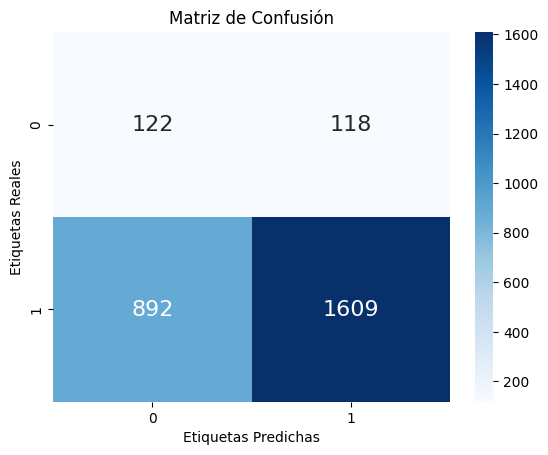

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.12      0.51      0.19       240
           1       0.93      0.64      0.76      2501

    accuracy                           0.63      2741
   macro avg       0.53      0.58      0.48      2741
weighted avg       0.86      0.63      0.71      2741



In [1120]:
from sklearn.utils import resample


train_tokenized2 = train_tokenized.copy() 
test_tokenized2 = test_tokenized.copy() 
validation_tokenized2 = validation_tokenized.copy() 

train_tokenized2['game_score'] = pd.DataFrame(train_data['game_score'].apply(pd.Series).stack().reset_index(level=1, drop=True).reset_index(drop = True)).rename(columns = {0:'game_score'})
test_tokenized2['game_score'] = pd.DataFrame(test_data['game_score'].apply(pd.Series).stack().reset_index(level=1, drop=True).reset_index(drop = True)).rename(columns = {0:'game_score'})
validation_tokenized2['game_score'] = pd.DataFrame(validation_data['game_score'].apply(pd.Series).stack().reset_index(level=1, drop=True).reset_index(drop = True)).rename(columns = {0:'game_score'})

train_tokenized2['game_score'] =  train_tokenized2['game_score'].astype(int) 
test_tokenized2['game_score'] =  test_tokenized2['game_score'].astype(int) 
validation_tokenized2['game_score'] =  validation_tokenized2['game_score'].astype(int) 

train_speakers = pd.DataFrame(train_data['speakers'].apply(pd.Series).stack().reset_index(level=1, drop=True).reset_index(drop = True)).rename(columns = {0:'speakers'})
train_speakers_OHE = onehot_encode_column(train_speakers, 'speakers')
# Procesan los datos para obtener las variables exogenas sumadas al texto
train_tokenized_result = preprocess_data(train_tokenized2, tokenizer, train_speakers_OHE,use_fit_transform=True)
train_tokenized_result['attention_mask'] = train_tokenized_result['input_ids'].apply(create_attention_mask)

test_speakers = pd.DataFrame(test_data['speakers'].apply(pd.Series).stack().reset_index(level=1, drop=True).reset_index(drop = True)).rename(columns = {0:'speakers'})
test_speakers_OHE = onehot_encode_column(test_speakers, 'speakers')
# Procesan los datos para obtener las variables exogenas sumadas al texto
test_tokenized_result = preprocess_data(test_tokenized2, tokenizer, test_speakers_OHE,use_fit_transform=False)
test_tokenized_result['attention_mask'] = test_tokenized_result['input_ids'].apply(create_attention_mask)

validation_speakers = pd.DataFrame(validation_data['speakers'].apply(pd.Series).stack().reset_index(level=1, drop=True).reset_index(drop = True)).rename(columns = {0:'speakers'})
validation_speakers_OHE = onehot_encode_column(validation_speakers, 'speakers')
# Procesan los datos para obtener las variables exogenas sumadas al texto
validation_tokenized_result = preprocess_data(validation_tokenized2, tokenizer, validation_speakers_OHE,use_fit_transform=False)
validation_tokenized_result['attention_mask'] = validation_tokenized_result['input_ids'].apply(create_attention_mask)



df_class_0 = train_tokenized_result[train_tokenized_result['label'] == 0] 
df_class_1 = train_tokenized_result[train_tokenized_result['label'] == 1]

# Submuestrear la clase mayoritaria (clase 1) a 591 instancias
df_class_1_resampled = resample(df_class_1, replace=False, n_samples=591, random_state=42) 

# Combinar las clases equilibradas
df_balanced = pd.concat([df_class_0, df_class_1_resampled]).reset_index(drop = True) 


# Definir las características
features = Features({
    'label': ClassLabel(names=[0, 1], id=None),
    'input_ids': Sequence(feature=Value(dtype='int64', id=None)),
    'attention_mask': Sequence(feature=Value(dtype='int64', id=None)), 
})  

df_balanced.reset_index(drop=True, inplace=True)

# Crear el conjunto de datos
train_dataset = Dataset.from_pandas(df_balanced, features=features)
test_dataset = Dataset.from_pandas(test_tokenized_result, features=features) 
validation_dataset = Dataset.from_pandas(validation_tokenized_result, features=features)


dataset_dict = DatasetDict({
    "train": train_dataset,
    "test": test_dataset,
    "validation": validation_dataset,
})

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# import accuracy evaluation metric
accuracy = evaluate.load("accuracy")

# se define una funcion de evaluacion que sera utilizada en el entranmiento
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)}

peft_config = LoraConfig(task_type="SEQ_CLS", # sequence classification
                        r=4, # intrinsic rank of trainable weight matrix
                        lora_alpha=32, # used for scalling the LoRA reparametrization .
                        lora_dropout=0.01, # probablity of dropout
                        target_modules = ['q_lin']) # we apply LoRA to query layer only

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# hyperparametros
lr = 0.001# size of optimization step 
batch_size = 3 # number of examples processed per optimziation step
num_epochs = 5 # number of times model runs through training data

# define training arguments
training_args = TrainingArguments(
    output_dir= modelo + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)


# creater trainer object
trainer2 = Trainer(
    model=model, # our peft model
    args=training_args, # hyperparameters
    train_dataset= dataset_dict['train'], # training data 
    eval_dataset=dataset_dict['test'], # test data  
    tokenizer=tokenizer, # define tokenizer
    data_collator=data_collator, # this will dynamically pad examples in each batch to be equal length
    compute_metrics=compute_metrics, # evaluates model using compute_metrics() function from before
)

# train model
trainer2.train()

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("Trained model predictions:")
print("--------------------------")
for text in train_tokenized2[['text']].iloc[1]:  
    # Tokeniza y codifica el texto
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    # Realiza la inferencia en el modelo
    logits = model(inputs).logits
    predictions = torch.max(logits, 1).indices
    print(id2label[predictions.tolist()[0]]) 

    print(text + " - " + id2label[predictions.tolist()[0]])


# realizamos las predicciones para los datos de testeo para calcular las metricas y ver la calidad del modelo con los datos utilizados
prediction_f = []
for index, row in test_tokenized2.iterrows(): 
    text = row['text']

    # Tokeniza y codifica el texto
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    # Realiza la inferencia en el modelo
    logits = model(inputs).logits
    predictions = torch.max(logits, 1).indices
    prediction_f.append([text, predictions.tolist()[0]])
if len(prediction_f) > 0:
    result = pd.DataFrame(prediction_f).rename(columns={0:'text',1:'label_predicted'})


from sklearn.metrics import accuracy_score, confusion_matrix


accuracy = accuracy_score(test_tokenized['label'], result['label_predicted'])
print(f'Accuracy: {accuracy:.2f}')

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(test_tokenized['label'], result['label_predicted'])
print('Confusion Matrix:')
print(conf_matrix)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(test_tokenized['label'], result['label_predicted'])

# Calcula el reporte de clasificación
class_report = classification_report(test_tokenized['label'], result['label_predicted'])

# Crea un mapa de calor de la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Reales')
plt.title('Matriz de Confusión')
plt.show()

# Imprime el reporte de clasificación
print("Reporte de Clasificación:")
print(class_report)

Conclusion 4

# Conclusion 2

Se puede observar una disminucion en la precision en el modelo, sin embargo la matrix de confusion evidencia un gran porcentaje en falsos positivos y falsos negativos (aunque en este casi disminuyeron los falsos negativos), para la clase minoritaria respecto a su mimsma proporcion de clases, la etiqueta de 0 clasifica la mayor cantidad como falsos positivos. En este caso se modifico la matriz de entrada de los datos de manera manual, para incorporar dos nuevas variables que son el game_score y el speaker (que me dice el pais de donde pertenece cada frase).

Se podrian aplicar otras tecnicas para tratar el desbalanceo de clases o aumentando la data. Ademas, es posible probar mas hiperparametros y tratar de mejorar el score de la metrica y tratar los falsos positivos a traves de otros modelos de clasificacion que permitan modificar la probabilidad de que un valor pertenezca a una clase, por lo general el umbral suele ser del 0.5 y a partir de ahi se determina si es 1 o 0, una solucion seria aumentar ese umbral para tratar el problema en la precision del modelo. </br>

El recall da cuenta sobre cuantos valores positivos son correctamente clasificados, en este caso el recall  para la prediccion de 1 (verdad) =  0.64, mientras que para 0 el recall es = 0.51. </br>

La precision me explica cuanto porcentaje de valores que se han clasificado como positivos son realmente positivos, en este caso para el valor de 1 la precision toma un valor de 0.93 o un 93% y para 0 toma el valor de 0.12, en este caso se concluye que el modelo tiene problemas para distinguir las mentiras de las verdades. </br>

El f1 score evidencia que para la clase cero falla casi en todo el tiempo (f1 = 0.19), mientras que para la clase 1 (f1 = 0.76) el valor es mayor. El f1 score alcanza su maximo cuando la precision y la exhaustividad son perfectas. Esta metrica es util en situaciones donde clasificar correctamente las instancias positivas es tan importante como minimizar los falsos positivos y los falsos negativos.

Si bien no se realizo esto en el codigo debido al tiempo, si que es posible mejorar el modelo o utilizar un modelo mas robusto u otras tecnicas mas comunes para llegar a detectar una verdad o una mentira en el texto.
Es importante conocer mas a fondo el modelo a utilizar y con que data fue entrenado ya que esto puede afectar el resultado final. Si bien distilbert-base-uncased es pequeño, se pueden implementar modelos mas robustos como: roberta-base, llama2, gpt2. 

La tenica de fine tunung añadiendo nuevos parametros de entrenamiento utilizando el low rank adaptation (LoRA) en este caso sirve para utilizar nuevos datos de entramiento y añadirlos al modelo, dejando los parametros de W0 fijos y optimizando los pesos de los delta-W.


-------------------------------------------------------------------------- COMPARACION MODELO - ARTICULO -------------------------------------------------------------------

El modelo - It Takes Two to Lie: One to Lie, and One to Listen, se basa en diferentes modelos de machine learning y deep learning para detectar una mentira. Los investigadores dedican un esferzo en entender completamente el juego y las condiciones del mismo ya que puede durar hasta un año, y se toman decisiones para la clasificacion a partir de textos largos que contengan verdad y mentira juntos,  para no sesgar el resultado. 
En el articulo tratan el problema con detectar lo que es una mentira y lo que se percibe como una mentira, sin embargo no es tan sencillo ya que la mayoria de las afirmaciones no son mentiras, menos del cinco por ciento de los mensajes se etiquetan como mentiras en ambas tareas de mentira real y sospecha de mentira.
Los resultados utilizan una característica de F1 ponderada en la predicción de verdad y mentira, ya que la precisión es una métrica inflada dada la desigualdad de clases. Se adopta un enfoque de entrenamiento donde las predicciones incorrectas de mentiras se penalizan más que las afirmaciones verídicas. La penalización relativa entre las dos clases es un hiperparámetro ajustado en F1. Los investigadores se centran en la detección de mentiras, donde los humanos tienen un F1 de Mentira del 22.5.

Para tratar el sobreajuste en los juegos se utilizan nueve juegos como datos de entrenamiento, uno se utiliza para validación para ajustar parámetros, y dos juegos son datos de prueba. Algunos jugadores se repiten entre los juegos.

PARA NUESTRO CASO, SE UTILIZAN LOS DATOS DE ENTRENAMIENTO Y LOS DATOS DE TESTEO PARA AJUSTAR PARAMETROS Y LOS DATOS DE VALIDACION PARA REALIZAR LAS PREDICCIONES.ESTO CON EL FIN DE QUE EL AJUSTE DE HIPERPARAMETROS TENGA EN CUENTA MAS DE 1 JUEGO. Y QUE LA PREDICCION FINAL SEA SIMPLEMENTE DE 1 SOLO JUEGO(validation). 

A DIFERENCIA DEL MODELO IMPLEMENTADO, EN EL ARTICULO USAN UN MODELO DE REGRESION LOGISTICA DONDE LOS COEFICIENTES PUEDEN SER INTERPRETABLES DONDE LAS PALABRAS SE PUEDEN RELACIONAR CON MENTIRAS, POR EJEMPLO UNA PALABRA QUE OCURRE FRECUENTEMENTE PERO ES MENTIRA COMO: HONESTO, ABIERTAMENTE, AYUDAN IDENTIFICAR QUE MENSAJE ES MENTIRA. SE UTILIZA UN MODELO LINGUISTICO LLAMADO  "Linguistic Harbingers" QUE SIRVE PARA PREDECIR LA DECEPCION, EL CUAL CONTIENE UN CONJUNTO DE PALABRAS QUE SE UTILIZAN EN TEMAS INTERPERSONALES. DE ESTA MANERA AYUDAN A MEJORAR EL F1 SCORE A PARTIR DE ESTAS CARACTERISTICAS. EN LOS MODELOS IMPLEMENTADOS EN ESTE NOTEBOOK, SE BASA EN UN MODELO TRANSFORMER DISTILBERT QUE SE BASA EN LA ARQUITECTURA BERT- PERO ES MAS LIGERO Y EFICIENTE EN TERMINOS COMPUTACIONALES, EL CUAL CONTIENE YA UN ENTRENAMIENTO BASE CON EL CUAL TRABAJAR Y A PARTIR DE NUESTROS DATOS ETIQUETADOS ENTRENAR EL MODELO DE CLASIFICACION DEJANDO LOS DEMAS PARAMETROS CONGELADOS PARA ENTRENAR EL MODELO CON LA NUEVA INFORMACION, Y CON AYUDA DE ALGUNAS VARIABLES EXOGENAS PREDECIR LOS MENSAJES FALSOS Y VERDADEROS. 

El modelo utilizado en el articulo tiene en cuenta otros factores mas elaborados como las dinamicas de poder, las cuales influyen en la capacidad de mentir, ya que un jugador mas fuerte puede sentirse con la facultad de mentirle a otra persona. </br>
Por otro lado, se implementa una red neuronal (LSTM), para investigar las secuencias de las palabras que no se toman en cuenta en la regresion logistica con el fin de revelar mentiras. El LSTM jerarquico recibe el contexto de los mensajes anteriores al determinar si un mensaje dado es una mentira, lo cual es similar a la tarea de etiquetado que realizan los humanos al anotar los datos. El modelo hace esto codificando un solo mensaje a partir de los tokens y luego ejecutando un LSTM hacia adelante sobre todos los mensajes. Para cada mensaje, examina tanto el contenido como el contexto previo para decidir si el mensaje actual es una mentira. 

FINALMENTE, EL MODELO IMPLEMENTADO DE DISTILBERT NO EVIDENCIA UNA MEJORA NOTABLE EN EL F-1 SCORE, DEBIDO AL TAMAÑO DEL DATASET PARA LOS DATOS DE ENTRENAMIENTO.
QUEDA MAS CONFIGURACIONES POR IMPLEMENTARSE Y AÑADIR CAPAS OCULTAS EN LA ULTIMA CAPA DEL MODELO DE HUGGING FACE PARA MEJORAR LAS METRICAS DE EVALUACION. 


